# Analysis of the PMC-Patients Dataset
Link to paper: https://arxiv.org/abs/2202.13876

In [1]:
import pandas as pd

local_json_file_path = "pmc_datasets/"

try:
    patients_summaries = pd.read_json(local_json_file_path + "PMC-Patients.json")
    print("PMC-Patients.json loaded.")
except Exception as e:
    print(f"An error occurred: {e}")

print("-------------------------------------------------------")
patients_summaries.info()

PMC-Patients.json loaded.
-------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167034 entries, 0 to 167033
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   patient_id   167034 non-null  int64 
 1   patient_uid  167034 non-null  object
 2   PMID         167034 non-null  int64 
 3   file_path    167034 non-null  object
 4   title        167034 non-null  object
 5   patient      167034 non-null  object
 6   age          167034 non-null  object
 7   gender       167034 non-null  object
dtypes: int64(2), object(6)
memory usage: 10.2+ MB


In [2]:
patients_summaries.head()

,patient_id,patient_uid,PMID,file_path,title,patient,age,gender
0,0,7665777-1,33492400,comm/PMC007xxxxxx/PMC7665777.xml,Early Physical Therapist Interventions for Pat...,This 60-year-old male was hospitalized due to ...,"[[60.0, year]]",M
1,1,7665777-2,33492400,comm/PMC007xxxxxx/PMC7665777.xml,Early Physical Therapist Interventions for Pat...,A 39-year-old man was hospitalized due to an i...,"[[39.0, year]]",M
2,2,7665777-3,33492400,comm/PMC007xxxxxx/PMC7665777.xml,Early Physical Therapist Interventions for Pat...,One week after a positive COVID-19 result this...,"[[57.0, year]]",M
3,3,7665777-4,33492400,comm/PMC007xxxxxx/PMC7665777.xml,Early Physical Therapist Interventions for Pat...,This 69-year-old male was admitted to the ICU ...,"[[69.0, year]]",M
4,4,7665777-5,33492400,comm/PMC007xxxxxx/PMC7665777.xml,Early Physical Therapist Interventions for Pat...,This 57-year-old male was admitted to the ICU ...,"[[57.0, year]]",M


### Compute the average length of all titles:

In [36]:
title_lengths = [len(title) for title in patients_summaries.title]
pd.Series(title_lengths).describe()

count    167034.000000
mean         96.136242
std          34.578484
min           7.000000
25%          71.000000
50%          92.000000
75%         117.000000
max         377.000000
dtype: float64

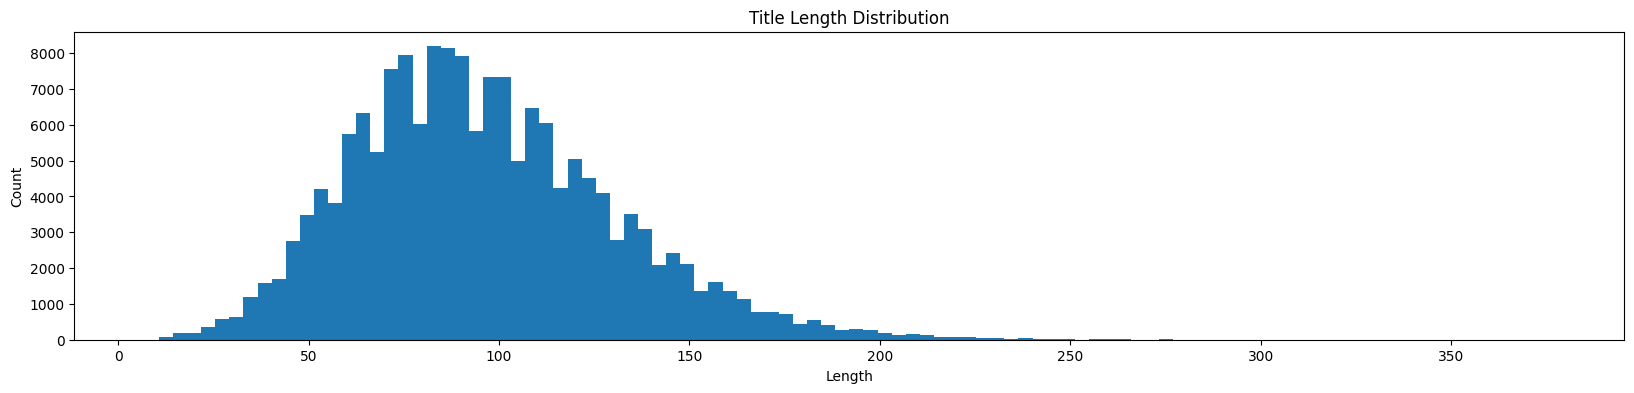

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.hist(title_lengths, bins=100, label="count")
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Title Length Distribution')
plt.show()

### Compute the average length of all patient summaries:

In [65]:
summary_lengths = pd.Series([len(summary) for summary in patients_summaries.patient])
summary_lengths.describe()

count    167034.000000
mean       2762.022696
std        1656.878042
min          55.000000
25%        1643.000000
50%        2489.000000
75%        3525.000000
max       95163.000000
dtype: float64

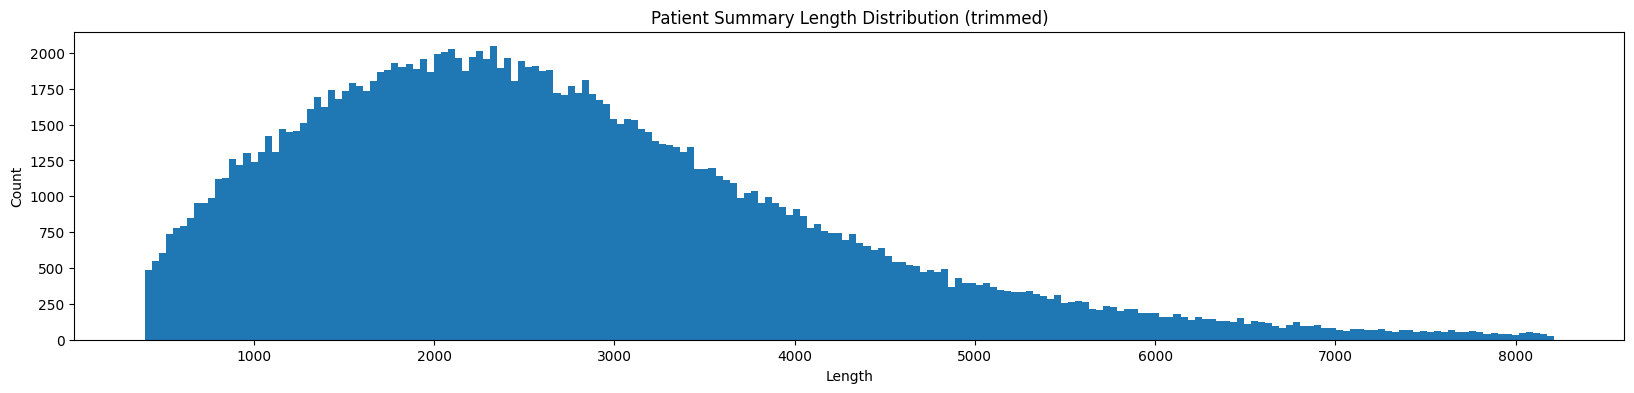

In [76]:
import numpy as np


quantile_1 = summary_lengths.quantile(0.01)
quantile_99 = summary_lengths.quantile(0.99)
index = summary_lengths[(summary_lengths >= quantile_95)|(summary_lengths <= quantile_5)].index

summary_lengths_cleaned = summary_lengths.drop(index, inplace=False)

plt.figure(figsize=(20, 4))
plt.hist(summary_lengths_cleaned, bins=200, label="count")
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Patient Summary Length Distribution (trimmed)')
plt.show()

### Generate random subsets for analysing the veterinary content:

In [ ]:
try:
    par_dataset = pd.read_json(local_json_file_path + "/PAR/PAR_corpus.jsonl", lines=True)
    print("PAR_corpus.jsonl loaded.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
try:
    ppr_dataset = pd.read_json(local_json_file_path + "/PPR/PPR_corpus.jsonl", lines=True)
    print("PPR_corpus.jsonl loaded.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
patients_summaries_samples = patients_summaries.sample(n=100, random_state=42)
ppr_dataset_samples = ppr_dataset.sample(n=100, random_state=42)
par_dataset_samples = par_dataset.sample(n=100, random_state=42)


In [ ]:
patients_summaries_samples.to_json("patients_summaries_samples", orient="records", lines=True, index=False)
ppr_dataset_samples.to_json("ppr_dataset_samples", orient="records", lines=True, index=False)
par_dataset_samples.to_json("par_dataset_samples", orient="records", lines=True, index=False)

Manual analysis of these random generated sample sets led to the following results:

|Sample Set|Veterinary Proportion|Extrapolation|
|:-----|:--------|:--------|
|Patients Summaries|1%|~ 1,670|
|Patients-Patients|1%|~ 62,000|
|Patients-Article|2%|~ 2,930|

# Analysis of PMC-Patients using fine-tuned SciBERT Model
### Load queried data

In [ ]:
from xml.etree.ElementTree import ElementTree
import pandas as pd

# Extract data from XML and create a DataFrame
xml_files = ["NEJM_data.xml", "animals_data.xml"]
data_path = "../edirect-python/results/"

data = []

tree = ElementTree()
hum_xml = tree.parse(data_path + xml_files[0])
for i, rec in enumerate(hum_xml.findall('.//Rec')):
    try: 
        common = rec.find('.//Common')
        pmid = common.find('PMID').text
        title = common.find('Title').text
        abstract = common.find('Abstract').text
        mesh_term_list = rec.find('.//MeshTermList')
        mesh_terms = [term.text for term in mesh_term_list.findall('MeshTerm')]
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Error occured for PMID: {pmid}")

    data.append({'pmid': pmid, 'title': title,
                'abstract': abstract, 'meshtermlist': mesh_terms, 'labels': [1,0]})
    if i > 499:
        break

vet_xml = tree.parse(data_path + xml_files[1])
for i, rec in enumerate(vet_xml.findall('.//Rec')):
    try: 
        common = rec.find('.//Common')
        pmid = common.find('PMID').text
        title = common.find('Title').text
        abstract = common.find('Abstract').text
        mesh_term_list = rec.find('.//MeshTermList')
        mesh_terms = [term.text for term in mesh_term_list.findall('MeshTerm')]
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Error occured for PMID: {pmid}")
    data.append({'pmid': pmid, 'title': title,
                'abstract': abstract, 'meshtermlist': mesh_terms, 'labels': [0,1]})
    if i > 5000:
        break

full_df = pd.DataFrame(data)

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-5
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")